In [1]:
from site_visit import *
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from scipy.spatial import distance_matrix
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

#color_lst = px.colors.qualitative.Light24

prop_cycle = plt.rcParams['axes.prop_cycle']
color_lst = prop_cycle.by_key()['color']

color_lst = px.colors.qualitative.Light24

In [2]:
# this takes a couple minutes
spatial_data = load_all_spatial_data("all_spatial_data_all_objs_relabspos_alignedsteps_featfilt.txt",
                                     fnames = None)

0 3_1b task1
500000 7_1a task1
1000000 9_1b task2


In [3]:
def prep_data(config):
    _data = [row for row in csv.DictReader(open(config['DATA']), delimiter='\t')]
    sys.stderr.write("Data: %d items\n"%len(_data))

    vocab_lsts, count_lsts = get_vocabs(_data, MODE=config['MODE'],
                                        K=config['K'], CUTOFF=config['CUTOFF'])
    
    #top_words = ["pick_VERB", "put_VERB", "hold_VERB", "eat_VERB"]
    top_words = get_top_words(config['POS'])
    #top_words = [w for i, w in enumerate(vocab_lsts[1])
    #             if (w.split('_')[1] == config['POS'] and count_lsts[1][i] >= 30)]
    
    _data = [d for d in _data if '%s_%s'%(d['lemma'], d['pos']) in top_words]
    sys.stderr.write("Filtered Data: %d items\n"%len(_data))
    
    X, y, meta, vocab = _make_raw_spatial_mats(_data, spatial_data, window_size = config['WINDOW'])
    
    #X, y, meta, vocab = make_token_mats(_data, vocab_lsts[0], K=config['K'],
    #                                    window_size = config['WINDOW'],
    #                                    mode=config['MODE'], use_objects=config['OBJS'])

    if config['MODE'] == 'random':
        rows, cols = X.shape
        X = np.random.rand(rows, cols)
    if config['MODE'] == 'oracle':
        rows, cols = X.shape
        words = sorted(list(set(y)))
        X = np.random.rand(rows, len(words))
        for i, w in enumerate(y):
            X[i, words.index(w)] = 1


    return vocab_lsts, count_lsts, top_words, X, y, meta, vocab

def filter_and_dedup(X, y, meta, top_words):
    X_filt, y_filt, m_filt = filter_mats(X, y, meta, top_words)

    dedup = []
    seen = set()
    for i, (mm, yy) in enumerate(zip(m_filt, y_filt)):
        part, task, steps = mm.split()
        if (part, task, yy) not in seen:
            seen.add((part, task, yy))
            dedup.append(i)

    X_filt = X_filt[dedup]
    y_filt = y_filt[dedup]
    m_filt = m_filt[dedup]
    
    return X_filt, y_filt, m_filt


In [11]:
def name_from_config(config):
    fnames = ['k', 'sup', 'red', 'dim', 'win']
    fs = ['K', 'SUP', 'RED', 'DIM', 'WINDOW']

    return '_'.join(['%s=%s'%(fnames[i], config[fs[i]]) for i in range(len(fs))])

def make_directories(config, make=False):

    #fnames = ['k', 'cutoff', 'sup', 'red', 'pos', 'dim', 'win']
    #fs = ['K', 'CUTOFF', 'SUP', 'RED', 'POS', 'DIM', 'WINDOW']
    fnames = ['k', 'sup', 'red', 'dim', 'win']
    fs = ['K', 'SUP', 'RED', 'DIM', 'WINDOW']

    # set up directories and such
    inp = config['DATA'].split('.')[0].split('/')[-1]
    if config['MODE'] in ['oracle', 'random']:
        inp = config['MODE']

    inp += '_'+ '_'.join(['%s=%s'%(fnames[i], config[fs[i]]) for i in range(len(fs))])

    repdir = 'reports_spatial/%s'%inp
    figdir = 'figures_spatial/%s'%inp
    
    if make:
        if not os.path.exists(repdir):
            os.makedirs(repdir)
        if not os.path.exists(figdir):
            os.makedirs(figdir)
        
    return repdir, figdir

def vocab_mat_figures(outpath, nm, mat, words, mn, mx, fmt='png', save=False):
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    plt.figure(figsize=(4, 0.2*len(words)))
    sns.heatmap(mat, cmap="coolwarm_r", vmin=mn, vmax=mx)
    plt.yticks(np.arange(len(words))+0.5, words, rotation="horizontal")
    if save:
        plt.savefig('%s/agg_%s.%s'%(outpath, nm, fmt), bbox_inches='tight')
    plt.show()
    plt.clf()
    
def vocab_mat_figures_indv(outpath, tup, mn, mx, fmt='png', save=False):
    use_X, use_y, use_m = tup
    for w in set(use_y):
        idx = [i for i, u in enumerate(use_y) if u == w]
        if len(idx) == 0:
            continue
        plt.figure(figsize=(4, 0.2*len(idx)))
        sns.heatmap(use_X[idx, :], cmap="coolwarm_r", vmin=mn, vmax=mx)
        plt.title(w)
        ticks = use_m[idx]
        plt.yticks(np.arange(len(ticks))+0.5, ticks, rotation="horizontal")
        if save:
            plt.savefig('%s/%s_full.%s'%(outpath, w, fmt), bbox_inches='tight')
        plt.show()
        plt.clf()
        
def avg_mat(tup, words):
    use_X, use_y, use_m = tup
    n_obs, n_feat = use_X.shape
    mat = np.zeros((len(words), n_feat))
    for i, w in enumerate(words):
        avg = use_X[use_y == w, :].sum(axis=0)
        mat[i, :] = avg
    return mat


def get_sims_avged(m1, m2, words, outfile, save=False):
    sims = cosine_similarity(m1, m2)
    ranks = []
    rand = []
    lines = []
    N = len(words)
    for i, w in enumerate(words):
        v1 = m1[i, :]
        v2 = m2[i, :]
        #print('m1', ' '.join(['%d'%e for e in v1]))
        #print('m2', ' '.join(['%d'%e for e in v2]))
        ssim = sims[i, i]
        
        max_idxs = [e for e in reversed(sims[i, :].argsort())] # to get descending order
        max_idx = max_idxs[0]
        
        # benefit-of-the-doubt MRR computation
        eq_set = np.where(sims[i, :] == ssim)[0] # all the words that have the same (max) similarity to query
        min_rank = N+1
        for idx in eq_set:
            min_rank = min(min_rank, np.where(max_idxs == idx)[0])
        ranks.append(1/(min_rank+1))
        rand.append(1/(random.choice(max_idxs)+1))
        lines.append((ssim, '%s\tselfsim=%.02f\trank=%d\tmaxsim=%s (%.02f)'%(w,
              ssim, min_rank, words[max_idx], sims[i, max_idx])))
    sum_line = "MRR = %.02f (Ceil=%.02f, Rand=%.02f, Floor=%.02f)"%(sum(ranks)/len(ranks),
                                                                    1, sum(rand)/len(rand), 1/N)
    if save:
        out = open(outfile, mode='w')
        out.write("%s\n"%(sum_line))
        for _, l in sorted(lines, key=lambda e:e[0], reverse=True):
            out.write(l+'\n')
        out.close()
    return sum_line

def get_sims(tr, dv, tr_lbl, dv_lbl, outfile, save=False):
    sims = cosine_similarity(dv, tr)
    #print(tr_lbl)
    #print(sims)
    ranks = []
    rand = []
    lines = []
    N = len(dv_lbl)
    by_lbl = {}
    for i, w in enumerate(dv_lbl):

        max_idxs = [e for e in reversed(sims[i, :].argsort())] # to get descending order
        max_idx = max_idxs[0]
        max_sim = sims[i, max_idx]
        
        print('%s\t%s\t%s'%(tr_lbl[max_idx] == w, w, tr_lbl[max_idx]))


In [12]:
def _max_dist_change_feats(ref, mat):
    dists = distance_matrix(ref.reshape(1, -1), mat)

    max_idx = [e for e in reversed(dists[0].argsort())][0]
    mx = dists[0, max_idx]

    mxx, mxy, mxz = mat[max_idx, :]
    names = ["change_start_max", "xchange_start_max",
             "ychange_start_max", "zchange_start_max"]
    feats = [mx, mxx, mxy, mxz]
    return feats, names

def _dist_change_feats(s, e):
    
    d = euclidean(s, e)

    names = ["change_start_end", "xchange_start_end",
             "ychange_start_end", "zchange_start_end"]
    feats = [d] + [s[i] - e[i] for i in range(3)]
    return feats, names

def _avg_pos_feats(span, dims):
    
    avg = span.mean(axis=0)

    names = ["%savg"%d for d in dims]
    feats = [avg[i] for i in range(len(dims))]
    return feats, names

def _var_feats(span, dims):
    
    avg = span.std(axis=0)

    names = ["%svar"%d for d in dims]
    feats = [avg[i] for i in range(len(dims))]
    return feats, names

def get_features(span, all_feats):
    #print(span.shape)
    feats = []
    names = []
    
    nsteps, nvals = span.shape

    # change in absoluate position, start to max
    px = all_feats.index('posX')
    py = all_feats.index('posY')
    pz = all_feats.index('posZ')
    fs, ns = _max_dist_change_feats(span[0, [px, py, pz]], span[:, [px, py, pz]])
    if np.isnan(fs).any():
        print("NaNs!! %s"%(' '.join(ns)), fs)
    #names += ["abs_"+e for e in ns]
    #feats += fs
    
    # change in absoluate position, start to end
    fs, ns = _dist_change_feats(span[0, [px, py, pz]], span[-1, [px, py, pz]])
    if np.isnan(fs).any():
        print("NaNs!! %s"%(' '.join(ns)), fs)
    #names += ["abs_"+e for e in ns]
    #feats += fs
    
    # change in relative position, start to max
    px = all_feats.index('relPosX')
    py = all_feats.index('relPosY')
    pz = all_feats.index('relPosZ')
    fs, ns = _max_dist_change_feats(span[0, [px, py, pz]], span[:, [px, py, pz]])
    if np.isnan(fs).any():
        print("NaNs!! %s"%(' '.join(ns)), fs)
    names += ["rel_"+e for e in ns]
    feats += fs
    
    # change in relative position, start to end
    fs, ns = _dist_change_feats(span[0, [px, py, pz]], span[-1, [px, py, pz]])
    if np.isnan(fs).any():
        print("NaNs!! %s"%(' '.join(ns)), fs)
    names += ["rel_"+e for e in ns]
    feats += fs
    
    # average relative position
    fs, ns = _avg_pos_feats(span[:, [px, py, pz]], ['x', 'y', 'z'])
    if np.isnan(fs).any():
        print("NaNs!! avg relpos %s"%(' '.join(ns)), fs)
        print(span[:, [px, py, pz]])
    names += ["rel_"+e for e in ns]
    feats += fs
    fs, ns = _var_feats(span[:, [px, py, pz]], ['x', 'y', 'z'])
    if np.isnan(fs).any():
        print("NaNs!! avg relpos %s"%(' '.join(ns)), fs)
        print(span[:, [px, py, pz]])
    names += ["rel_"+e for e in ns]
    feats += fs
    
    # average velocity
    px = all_feats.index('velX')
    py = all_feats.index('velY')
    pz = all_feats.index('velZ')
    fs, ns = _avg_pos_feats(span[:, [px, py, pz]], ['x', 'y', 'z'])
    if np.isnan(fs).any():
        print("NaNs!! avg vel %s"%(' '.join(ns)), fs)
        M = span[:, [px, py, pz]]
        rows, cols = M.shape
        for i in range(rows):
            if np.isnan(M[i, :]).any():
                print(i, M[i, :])

    #names += ["vel_"+e for e in ns]
    #feats += fs
    
    # average relative velocity
    px = all_feats.index('relVelX')
    py = all_feats.index('relVelY')
    pz = all_feats.index('relVelZ')
    fs, ns = _avg_pos_feats(span[:, [px, py, pz]], ['x', 'y', 'z'])
    if np.isnan(fs).any():
        print("NaNs!! avg relvel %s"%(' '.join(ns)), fs)
        print(span[:, [px, py, pz]])
    #names += ["vel_"+e for e in ns]
    #feats += fs
    
    return feats, names

In [13]:
def get_most_moving(obj_spans, fnames):
    max_objs = []
    x = fnames.index('velX')
    y = fnames.index('velY')
    z = fnames.index('velZ')
    for obj, span in obj_spans.items():
        vals, _ = _max_dist_change_feats(span[0, [x, y, z]], span[:, [x, y, z]])
        d = vals[0] # euclidean distance
        max_objs.append((obj, d))
    rank = sorted(max_objs, key=lambda e:e[1], reverse=True)
    return [o for o, _ in rank if 'Hand' not in o][0]
        
def _make_raw_spatial_mats(D, spatial_data, window_size=100):
    all_objs = ['RightHand', 'Apple', 'Ball', 'Banana', 'Bear', 'Book', 'Bowl', 'Cup',
                'Dinosaur', 'Doll', 'Fork', 'Head', 'Knife', 'Lamp', 'LeftHand',
                'Plant', 'Spoon', 'Toy']
    all_feats = ["relPosX", "relPosY", "relPosZ", "posX", "posY", "posZ",
                'velX', 'velY', 'velZ', 'relVelX', 'relVelY', 'relVelZ']
    
    use_objs = ['RightHand', 'LeftHand', 'Head']
    
    N = len(D)
    feats = []
    lbls = []
    meta = []
    for i, d in enumerate(D):
        sidx = int(d['step'])
        start = sidx-window_size
        end = sidx+window_size
        L = 1+end-start
        w = d['lemma']+'_'+d['pos']
        p = d['participant']
        t = d["task"]
        lbls.append(w)
        meta.append(p + ' ' + t + ' ' + '%s-%s'%(start, end))
        fv = []
        obj_spans = {o: np.zeros((L, len(all_feats))) for o in all_objs}
        for si, step in enumerate(range(start, end+1)):
            if step in spatial_data[(p, t)]:
                sdata = spatial_data[(p, t)][step]
                for obj in all_objs:
                    if obj in sdata:
                        frame = sdata[obj]
                        row = [frame[e] for e in all_feats]
                        if not(np.isnan(row).any()):
                            obj_spans[obj][si, :] = row
        for obj in use_objs:
            x, names = get_features(obj_spans[obj], all_feats)
            fv += x
        most_moving_obj = get_most_moving(obj_spans, all_feats)
        #if 'play' in w:
        #    print(w, most_moving_obj)
        x, names = get_features(obj_spans[most_moving_obj], all_feats)
        fv += x
        fv.append(all_objs.index(most_moving_obj))
        if np.isnan(fv).any():
            print("NaNs!!1", i, fv)
        feats.append(fv)
    return np.array(feats), lbls, meta, names

In [14]:
logging = True
sum_lines = []
data_file = 'aligned_data/may/partial_states_kappa=10.txt'
config = json.loads(open('config.json').read())
    
# overrides
config['DATA'] = data_file
config['K'] = 5
config['WINDOW'] = 90 # 90 = 1 second
config['RED'] = True
config['DIM'] = 50
config['SUP'] = True

In [15]:
repdir, figdir = make_directories(config, make=logging)

vocab_lsts, count_lsts, top_words_candidates, X, y, meta, vocab = prep_data(config)

print("X:", X.shape)
print("y:", len(y))

Data: 18825 items
Action Vocab=3181; Word Vocab=1324
Filtered Data: 968 items


X: (968, 57)
y: 968


In [16]:
X_filt, y_filt, m_filt = filter_and_dedup(X, y, meta, top_words_candidates)
top_words = list(set(y_filt))
train_tup, dev_tup, test_tup = train_test_split(X_filt, y_filt, m_filt, config['TEST'], config['DEV'])
    
X_train, y_train, m_train = train_tup
X_dev, y_dev, m_dev = dev_tup
#dev_tup = filter_and_dedup(X_dev, y_dev, m_dev, ["take_VERB", "walk_VERB"])
#X_dev, y_dev, m_dev = dev_tup

print("X_train:", X_train.shape)
print("X_dev:", X_dev.shape)
print("y_train:", len(y_train))
print("y_dev:", len(y_dev))

if config['RED'] == True:
    X_train, X_dev, X_test = reduce_mats(
                train_tup, dev_tup, test_tup,
                dim=config['DIM'], supervised=config['SUP'])
    train_tup = (X_train, train_tup[1], train_tup[2])
    dev_tup = (X_dev, dev_tup[1], dev_tup[2])
    test_tup = (X_test, test_tup[1], test_tup[2])
    print("X_train_red:", X_train.shape)
    print("X_dev_red:", X_dev.shape)

X_train: (358, 57)
X_dev: (27, 57)
y_train: 358
y_dev: 27
X_train_red: (358, 14)
X_dev_red: (27, 14)


Number of classes = 15
Training size = 358 x 57
Dim to reduce to = 50.000
/Users/ellie/miniconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning:

The priors do not sum to 1. Renormalizing

/Users/ellie/miniconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



False	go_VERB	wash_VERB
False	put_VERB	eat_VERB
False	stop_VERB	walk_VERB
False	eat_VERB	walk_VERB
True	go_VERB	go_VERB
False	walk_VERB	go_VERB
False	put_VERB	go_VERB
False	go_VERB	wash_VERB
False	wash_VERB	go_VERB
False	put_VERB	throw_VERB
False	get_VERB	hold_VERB
False	pick_VERB	stop_VERB
False	eat_VERB	put_VERB
True	put_VERB	put_VERB
False	go_VERB	put_VERB
False	take_VERB	stop_VERB
False	give_VERB	walk_VERB
False	put_VERB	go_VERB
False	go_VERB	put_VERB
False	eat_VERB	hold_VERB
True	hold_VERB	hold_VERB
False	put_VERB	eat_VERB
False	get_VERB	hold_VERB
False	throw_VERB	hold_VERB
False	go_VERB	pick_VERB
False	play_VERB	wash_VERB
False	wash_VERB	stop_VERB
None	reports_spatial/partial_states_kappa=10_k=5_sup=True_red=True_dim=50_win=90


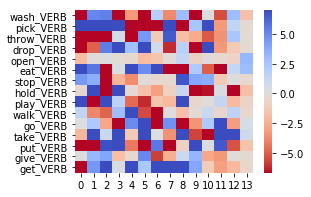

<Figure size 432x288 with 0 Axes>

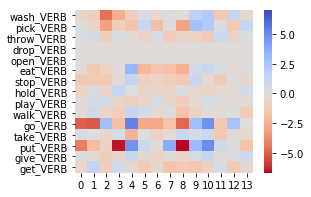

<Figure size 432x288 with 0 Axes>

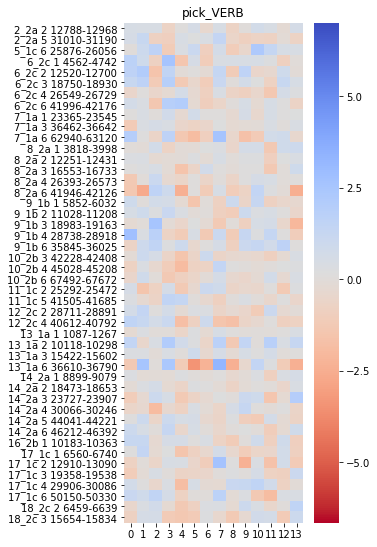

<Figure size 432x288 with 0 Axes>

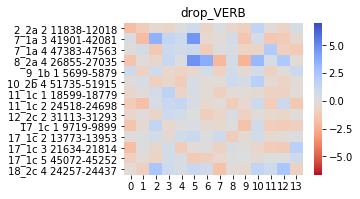

<Figure size 432x288 with 0 Axes>

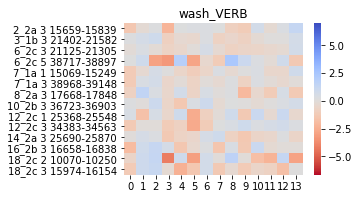

<Figure size 432x288 with 0 Axes>

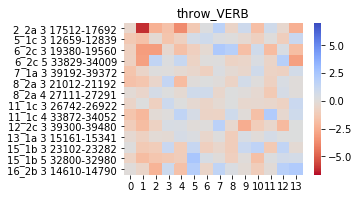

<Figure size 432x288 with 0 Axes>

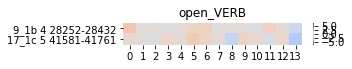

<Figure size 432x288 with 0 Axes>

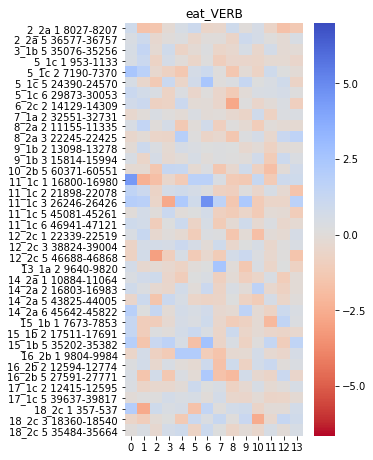

<Figure size 432x288 with 0 Axes>

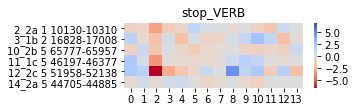

<Figure size 432x288 with 0 Axes>

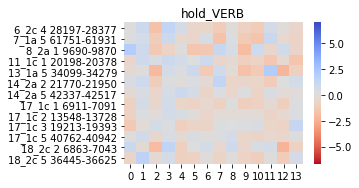

<Figure size 432x288 with 0 Axes>

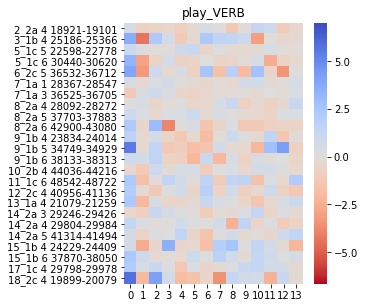

<Figure size 432x288 with 0 Axes>

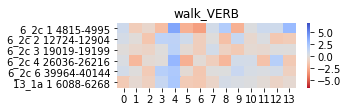

<Figure size 432x288 with 0 Axes>

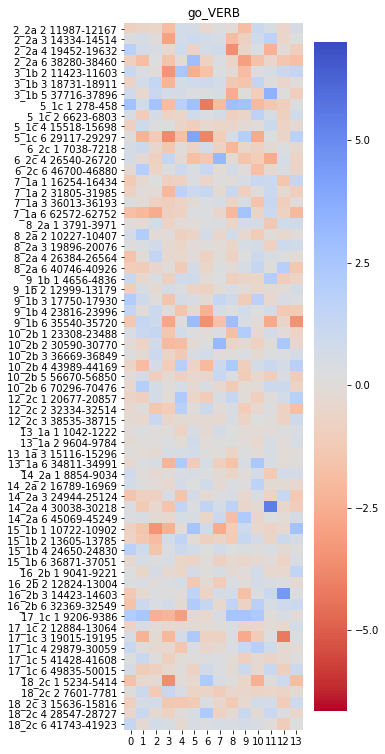

<Figure size 432x288 with 0 Axes>

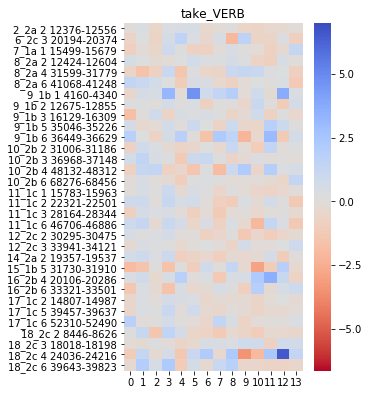

<Figure size 432x288 with 0 Axes>

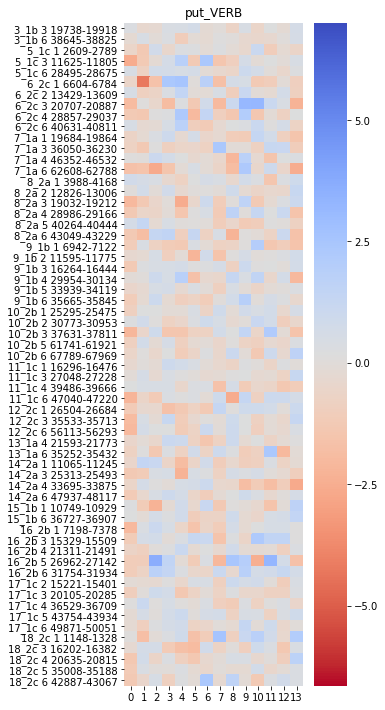

<Figure size 432x288 with 0 Axes>

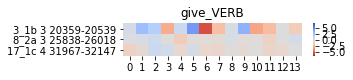

<Figure size 432x288 with 0 Axes>

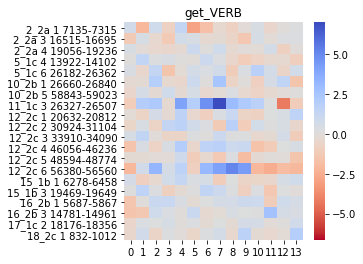

<Figure size 432x288 with 0 Axes>

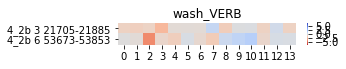

<Figure size 432x288 with 0 Axes>

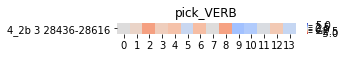

<Figure size 432x288 with 0 Axes>

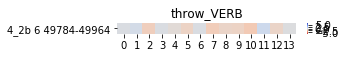

<Figure size 432x288 with 0 Axes>

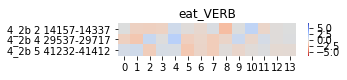

<Figure size 432x288 with 0 Axes>

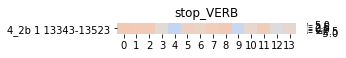

<Figure size 432x288 with 0 Axes>

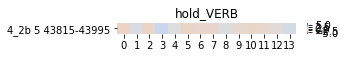

<Figure size 432x288 with 0 Axes>

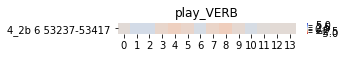

<Figure size 432x288 with 0 Axes>

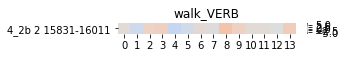

<Figure size 432x288 with 0 Axes>

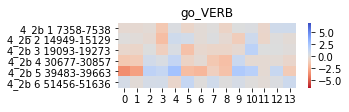

<Figure size 432x288 with 0 Axes>

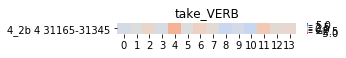

<Figure size 432x288 with 0 Axes>

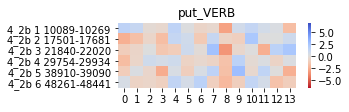

<Figure size 432x288 with 0 Axes>

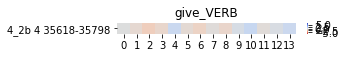

<Figure size 432x288 with 0 Axes>

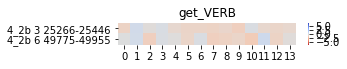

<Figure size 432x288 with 0 Axes>

In [20]:
outpath = figdir+'/notebook-figures'

#print(X_train)
mn = X_train.min()
mx = X_train.max()
avg_train = avg_mat(train_tup, top_words)
avg_dev = avg_mat(dev_tup, top_words)

sum_line = get_sims(avg_train, X_dev, top_words, y_dev,
#sum_line = get_sims(X_train, X_dev, y_train, y_dev,
                repdir+'/similarity_report.txt', save=logging)
print('%s\t%s'%(sum_line, repdir))
sum_lines.append('%s\t%s'%(sum_line, repdir))
#json.dump(config, open(repdir+'/config.json', 'w'))

if logging:
    vocab_mat_figures(outpath, 'raw_train', avg_train, top_words, mn, mx, 'png', save=logging)
    vocab_mat_figures(outpath, 'raw_dev', avg_dev, top_words, mn, mx, 'png', save=logging)
    vocab_mat_figures_indv(outpath, train_tup, mn, mx, 'png', save=logging)
    vocab_mat_figures_indv(outpath, dev_tup, mn, mx, 'png', save=logging)
        
if logging:
    out = open('reports/summary_%s.txt'%name_from_config(config), 'w')
    for line in sum_lines:
        out.write(line+'\n')
    out.close()

In [18]:
#reducer = TruncatedSVD(n_components=2)
reducer = TSNE(n_components=2, perplexity=10)

#red_tr = reducer.fit_transform(X_train_red)
#red_dv = reducer.fit_transform(X_dev_red)
print(X_train.shape)
print(X_dev.shape)
print(avg_train.shape)
print(avg_dev.shape)
red = reducer.fit_transform(np.vstack((X_train, X_dev, avg_train, avg_dev)))
#red = reducer.fit_transform(np.vstack((X_train, X_dev)))
#red = np.vstack((X_train, X_dev))
print(red.shape)

(358, 14)
(27, 14)
(15, 14)
(15, 14)
(415, 2)


['drop_VERB', 'eat_VERB', 'get_VERB', 'give_VERB', 'go_VERB', 'hold_VERB', 'open_VERB', 'pick_VERB', 'play_VERB', 'put_VERB', 'stop_VERB', 'take_VERB', 'throw_VERB', 'walk_VERB', 'wash_VERB']
['10_2b', '11_1c', '12_2c', '13_1a', '14_2a', '15_1b', '16_2b', '17_1c', '18_2c', '1_1a', '2_2a', '3_1b', '4_2b', '5_1c', '6_2c', '7_1a', '8_2a', '9_1b']


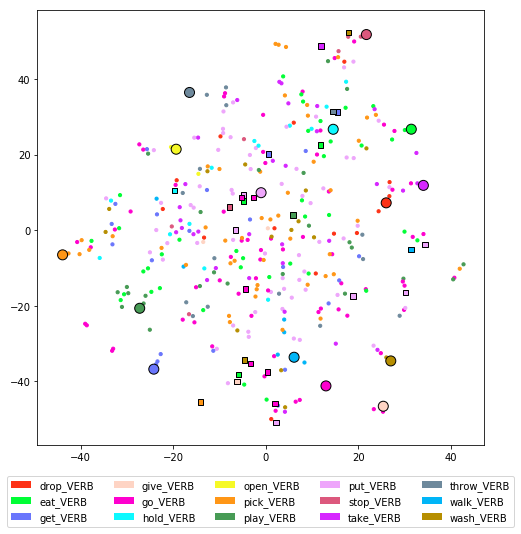

In [19]:
plt.figure(figsize=(8,8))

word_order = sorted(list(set(y_train)))
part_order = sorted(list(set([e.split()[0] for e in meta])))
print(word_order)
print(part_order)
train_end = len(y_train)
dev_end = train_end + len(y_dev)
avg_train_end = dev_end + len(top_words)
avg_dev_end = avg_train_end + len(top_words)

color_by_word = True

L = len(color_lst)

# train words
if color_by_word:
    tr_colors = [color_lst[word_order.index(y)%L] for y in y_train]
    dv_colors = [color_lst[word_order.index(y)%L] for y in y_dev]
else:
    tr_colors = [color_lst[part_order.index(p.split()[0])%L] for p in m_train]
    dv_colors = [color_lst[part_order.index(p.split()[0])%L] for p in m_dev]
    
plt.scatter(red[:train_end, 0], red[:train_end, 1], s=10, color=tr_colors)

# centroids of train words
if color_by_word:
    plt.scatter(red[dev_end:avg_train_end, 0], red[dev_end:avg_train_end, 1], s=100,
            color=[color_lst[word_order.index(y)%L] for y in top_words], linewidth=1, edgecolor='k')

# dev words
plt.scatter(red[train_end:dev_end, 0], red[train_end:dev_end, 1], s=30, color=dv_colors,
            marker='s', linewidth=1, edgecolor='k')

# centroids of dev words
#plt.scatter(red[avg_train_end:, 0], red[avg_train_end:, 1], s=50,
#            color=[color_lst[word_order.index(y)%L] for y in top_words], marker='s', linewidth=1, edgecolor='k')

if color_by_word:
    legend_elements = [Patch(facecolor=color_lst[i%L], label=word_order[i]) for i in range(len(word_order))]
else:
    legend_elements = [Patch(facecolor=color_lst[i%L], label=part_order[i]) for i in range(len(part_order))]
plt.legend(handles=legend_elements, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.2))

plt.savefig("big_scatter.pdf", bbox_inches='tight')
plt.show()

In [ ]:
for i in range(8):
    print(vocab[i])
    plt.hist([X_train[[i for i,y in enumerate(y_train) if (y == 'pick_VERB') ], i],
         X_train[[i for i,y in enumerate(y_train) if (y == 'put_VERB') ], i]], normed=True)
    plt.show()